<br><img src="Data/2.png" oncontextmenu="return false" style="margin-left:-5px;pointer-events:none;-webkit-touch-callout:none;-webkit-user-select:none;-ms-user-select:none;user-select:none;" />

<font size=3><ul><li>Suganthan Thamotharampillai
<br><li>01.31.2023
<div style="border-style:solid;border-color:red;border-width:10px;border-width:0px;border-top-width:7px;">

<br><b><font style="font-size:20px;">Imports</font>

In [12]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, json, math, time
from yelpapi import YelpAPI
pd.options.display.max_colwidth=12

<br><b><font style="font-size:20px;">API Credentials and Yelp Object</font>

In [9]:
# API Credentials
with open('/Users/sugan/.secret/yelp_api.json') as f:
    login = json.load(f)
login.keys()

dict_keys(['client-id', 'api-key'])

In [10]:
# YelpAPI Object
yelp_api = YelpAPI(login['api-key'], timeout_s=5.0)
yelp_api

<br><b><font style="font-size:20px;">Define Search Terms and File Paths</font>

In [4]:
# Setting API Parameters
LOCATION = 'Buffalo'
TERM = 'Indian Cuisine'
print(TERM, LOCATION)

Indian Cuisine Buffalo


In [6]:
# Specifying JSON_FILE Name&Path
JSON_FILE = f"Data/ApiResults/results_in_progress_{(TERM+LOCATION).replace(',','').replace(' ','')}.json"
JSON_FILE

'Data/ApiResults/results_in_progress_IndianCuisineBuffalo.json'

<br><b><font style="font-size:20px;">Creating JSON File</font>

In [9]:
## JSON_FILE Extant State
file_exists = os.path.isfile(JSON_FILE)

## If Non-Extant:
if file_exists == False:
    
    ## Create Needed Folder
    folder = os.path.dirname(JSON_FILE)
    ## If JSON_FILE included a folder:
    if len(folder) > 0:
        # Create the folder
        os.makedirs(folder,exist_ok=True)
        
    # Inform User
    print(f'{JSON_FILE} not found. Saving empty list to file.')
    
    with open(JSON_FILE,'w') as f:
        json.dump([],f)
    if os.path.isfile(JSON_FILE) == True:
        print(f'{JSON_FILE} created.')
        
# If Extant:
else:
    print(f"{JSON_FILE} already exists.")

Data/ApiResults/results_in_progress_IndianCuisineBuffalo.json not found. Saving empty list to file.
Data/ApiResults/results_in_progress_IndianCuisineBuffalo.json created.


<br><b><font style="font-size:20px;">Prerequisite</font>

<b>1. Determine how many results are already in the file

In [7]:
# Load previous results and find length for offset
with open(JSON_FILE,'r') as f:
    previous_results = json.load(f)
    
# Offset
n_results = len(previous_results)
print(f'There are {n_results} previous results found.')

There are 52 previous results found.


<b>2. Figure out how many pages of results we will need

In [10]:
# Yelp_api's search_query Method
results = yelp_api.search_query(location=LOCATION,
                                term=TERM,
                               offset=n_results)
results.keys()

dict_keys(['businesses', 'total', 'region'])

In [11]:
# How many results found?
total_results = results['total']
print(f"There are {total_results} matches for Indian Cuisine in Buffalo City")

There are 63 matches for Indian Cuisine in Buffalo City


In [12]:
# How many did we get the details for?
results_per_page = len(results['businesses'])
print(f"There are {results_per_page} results per page")

There are 20 results per page


In [13]:

# Use math.ceil to round up for the total number of pages of results.
n_pages = math.ceil((results['total']-n_results)/ results_per_page) #ceil seals the integer rounding it upward
print(f"Calculating results over results per page, we get a total number of {n_pages} pages")

Calculating results over results per page, we get a total number of 4 pages


<b>3. Set up a Progress Bar to monitor Api Call

In [14]:
from tqdm.notebook import tqdm_notebook as tqdm
tqdm

tqdm.notebook.tqdm_notebook

<br><b><font style="font-size:20px;">API Call</font>

In [15]:
## The API Call
## Loop
for i in tqdm(range(1,n_pages+1), colour='red'):
    
    # Read in 'results-in-progress' file for length
    with open(JSON_FILE, 'r') as f:
        previous_results = json.load(f)
        
    # Number of results for Offset
    n_results = len(previous_results)
        
    # Safeguard for Exceeding 1000 YelpApi Calls
    if (n_results + results_per_page) > 1000:
        print('Exceeded 1000 Api calls. Loop Stopped.')
        break
    
    # Use n_results as OFFSET 
    results = yelp_api.search_query(location=LOCATION,
                                    term=TERM, 
                                    offset=n_results+1)
    
    # Append new results to file
    previous_results.extend(results['businesses'])
    
    # Dump to JSON
    with open(JSON_FILE,'w') as f:
        json.dump(previous_results,f)
    
    # Add a 200ms pause
    time.sleep(.2)

  0%|          | 0/4 [00:00<?, ?it/s]

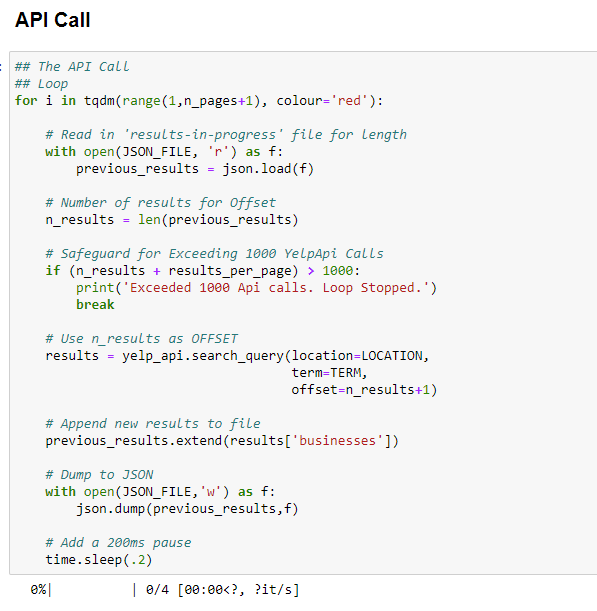

<br><b><font style="font-size:20px;">Convert .json to PANDAS dataframe</font>

In [16]:
## Convert final results as PANDAS Dataframe
df = pd.read_json(JSON_FILE)

<b>1. Check for duplicates

In [17]:
## Check and Drop duplicate ids and confirm
df = df.drop_duplicates(subset='id')
df.duplicated(subset='id').sum()

0

<b>2. Display

In [18]:
# Dataframe
pd.concat([df.head(), df.tail()])

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone,distance
0,RtTKpizy...,spices-o...,Spices o...,https://...,False,https://...,245,[{'alias...,4.5,{'latitu...,[deliver...,$$,{'addres...,+1716633...,(716) 63...,8061.156056
1,2Ibo1K9G...,clay-han...,Clay Handi,https://...,False,https://...,238,[{'alias...,4.0,{'latitu...,[deliver...,$$,{'addres...,+1716877...,(716) 87...,6486.388698
2,PmALs1uA...,nellai-b...,Nellai B...,https://...,False,https://...,129,[{'alias...,4.0,{'latitu...,[deliver...,$$,{'addres...,+1716276...,(716) 27...,10461.94...
3,LkTReC8T...,taj-gril...,Taj Grill,https://...,False,https://...,348,[{'alias...,4.0,{'latitu...,[deliver...,$$,{'addres...,+1716875...,(716) 87...,5009.389486
4,5s_kMLz3...,zaika-in...,Zaika In...,https://...,False,https://...,722,[{'alias...,4.0,{'latitu...,[deliver...,$$,{'addres...,+1716804...,(716) 80...,26906.41...
47,JGsTIMzr...,mela-ind...,Mela Ind...,,False,https://...,4,[{'alias...,1.5,{'latitu...,[],NaN,{'addres...,,,26744.85...
48,8b32gWkV...,a-1-dosa...,A-1 Dosa...,,False,https://...,14,[{'alias...,1.5,{'latitu...,[],$$,{'addres...,,,26920.45...
49,1xnk1X5q...,india-ki...,India Ki...,https://...,False,https://...,24,[{'alias...,1.5,{'latitu...,[],$$,{'addres...,+1716285...,(716) 28...,27100.09...
50,YeulOE9R...,fallsvie...,Fallsvie...,https://...,False,https://...,91,[{'alias...,3.0,{'latitu...,[],$$$,{'addres...,+1905374...,+1 905-3...,27899.24...
51,HpfFyF_c...,passage-...,Passage ...,https://...,False,https://...,45,[{'alias...,3.5,{'latitu...,[],$$,{'addres...,+1905371...,+1 905-3...,28311.44...


<br><b>3. Final Save

In [19]:
# Save final results to a compressed csv
CSVGZ_FILE = f"Data/ApiResults/final_results_{(TERM+LOCATION).replace(',','').replace(' ','')}.csv.gz"
df.to_csv(CSVGZ_FILE, compression='gzip', index=False)

In [20]:
# Check for Extant
if os.path.isfile(CSVGZ_FILE) == True: print(f'Dataframe as {CSVGZ_FILE} file is \nSuccessfully Created.')

Dataframe as Data/ApiResults/final_results_IndianCuisineBuffalo.csv.gz file is 
Successfully Created.


<img oncontextmenu="return false" style="display:inline;margin-left:-5px;opacity:.07;pointer-events:none;-webkit-touch-callout:none;-webkit-user-select:none;-ms-user-select:none;user-select:none;" src="Data/yelp-logo.png" width="12%" />